In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder

from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have one GPU
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.
GPU Device Name: Tesla T4


In [ ]:
# Assuming you have a CSV file with image file paths and corresponding solar irradiance values
csv_path = '/content/drive/My Drive/Image Dataset Curation/Image_Dataset_Final.csv'

# Load the dataset
df = pd.read_csv(csv_path)

In [ ]:
"""
df contains paths to the segmented image and the corresponding solar irradiance value
"""
print(df.shape)
df.head()

(7209, 3)


,image_path,datetime,Avg Global CMP22 (vent/cor) [W/m^2]
0,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 07:00:00,63.8407
1,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 08:00:00,176.1522
2,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 09:00:00,361.7695
3,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 10:00:00,582.2481
4,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 11:00:00,632.4995


Image path:	 /content/drive/MyDrive/Image Dataset Curation/Final_Images/20211008080000_12_UE.jpg


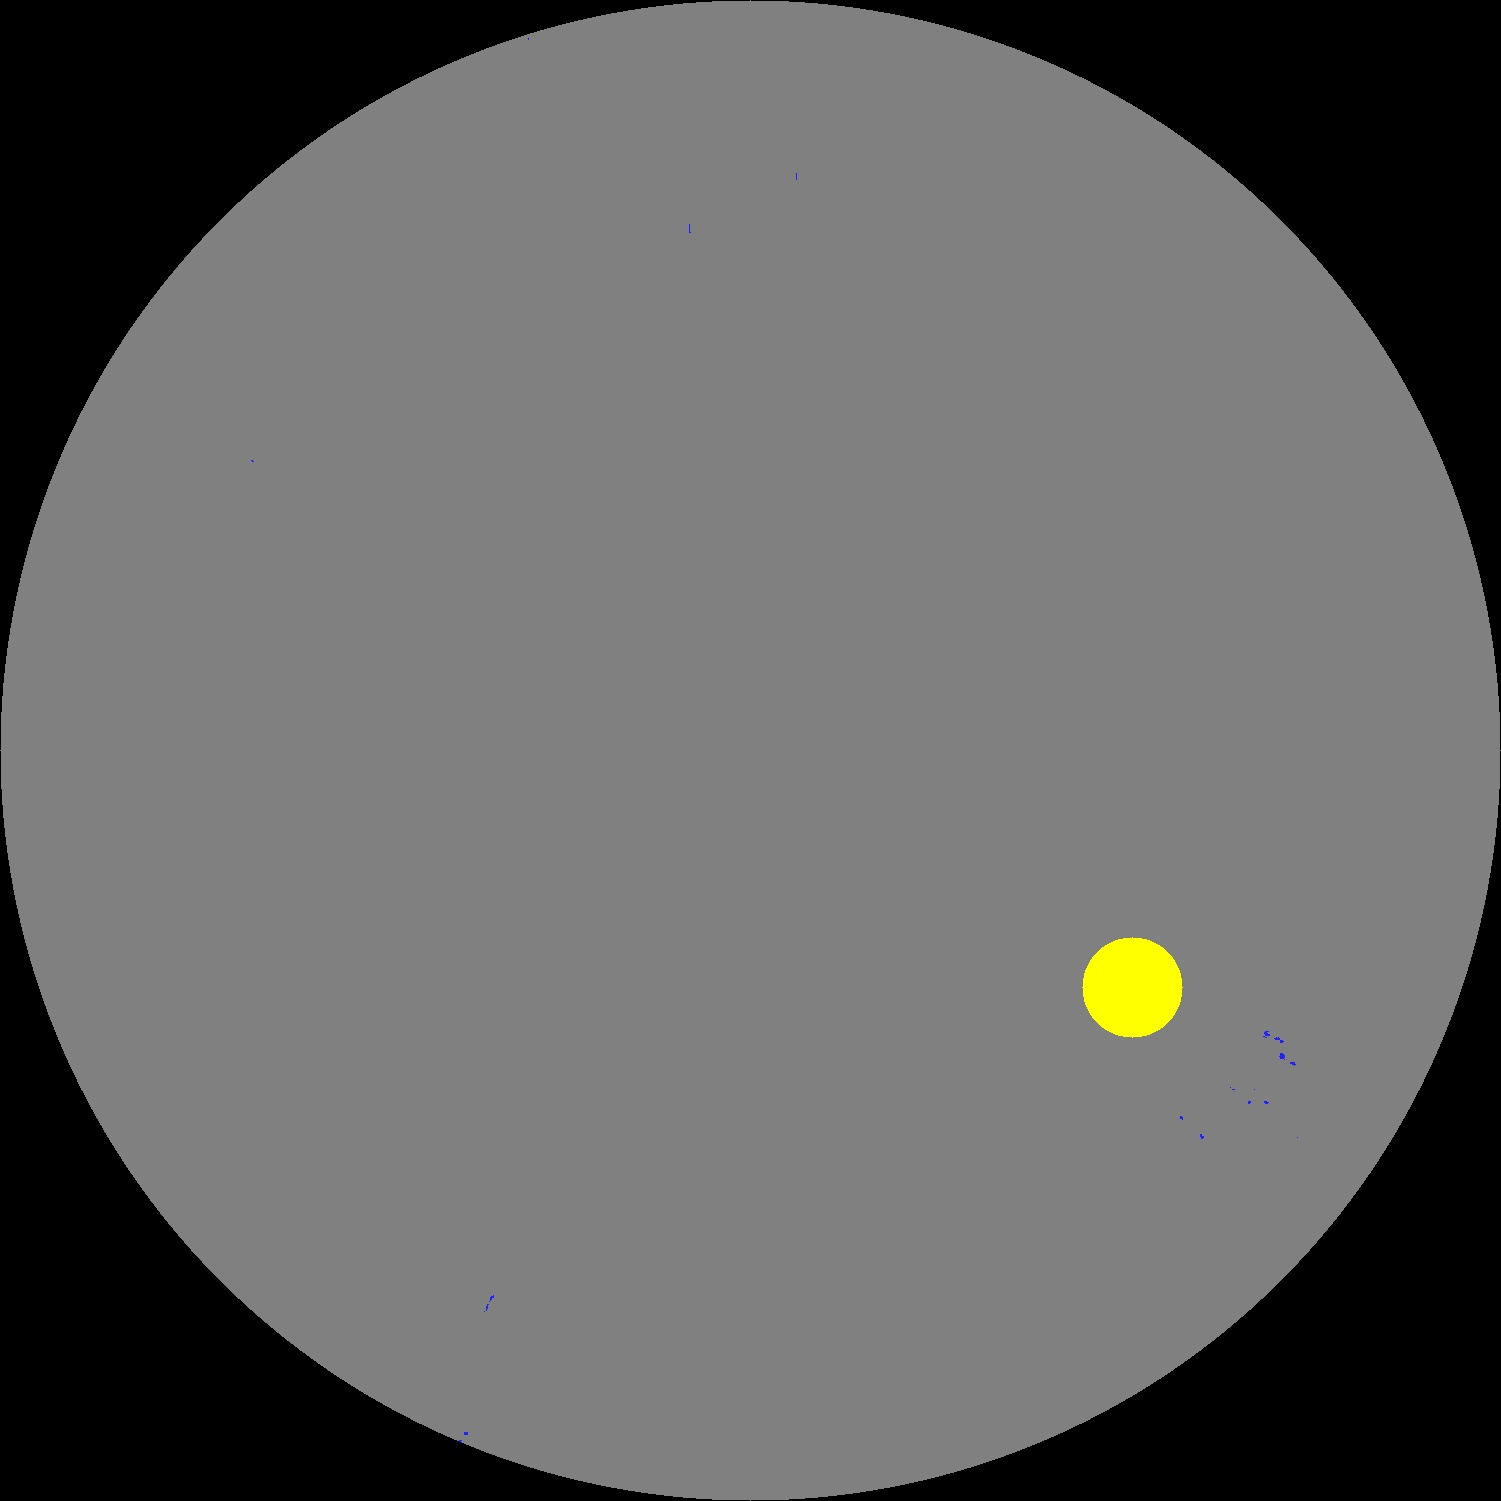

In [ ]:
# image path
img = df["image_path"][1]
print("Image path:\t", img)

# load image and display
im = Image.open(img)
im

In [ ]:
# Sort dataset by datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')
df.set_index('datetime', inplace=True)
df.head()

,image_path,Avg Global CMP22 (vent/cor) [W/m^2]
datetime,,
2021-10-08 07:00:00,/content/drive/MyDrive/Image Dataset Curation/...,63.8407
2021-10-08 08:00:00,/content/drive/MyDrive/Image Dataset Curation/...,176.1522
2021-10-08 09:00:00,/content/drive/MyDrive/Image Dataset Curation/...,361.7695
2021-10-08 10:00:00,/content/drive/MyDrive/Image Dataset Curation/...,582.2481
2021-10-08 11:00:00,/content/drive/MyDrive/Image Dataset Curation/...,632.4995


In [ ]:
# Dataset split into training, validation, and testing
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

train_index = int(train_percentage * len(df))
val_index = int((train_percentage + val_percentage) * len(df))

# Split the data
train_df = df[:train_index]
val_df = df[train_index:val_index]
test_df = df[val_index:]

In [ ]:
print(f"train:\t{train_df.shape},\nval:\t{val_df.shape},\ntest:\t{test_df.shape}")

train:	(4325, 2),
val:	(1442, 2),
test:	(1442, 2)


In [ ]:
# Curate dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError as e:
            print(f"File not found at {idx}: {img_path}")
            # Handle the error, log it, or take appropriate action
        except OSError as e:
            print(f"Error  at {idx}: {e}")
            # Handle the error, log it, or take appropriate action
        # image = Image.open(img_path).convert('RGB')
        target = torch.tensor(float(self.data.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)
        return image, target

In [ ]:
# Dataset and DataLoader for training and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

In [ ]:
train_dataset[0][0][0][0].shape
# train_dataset[0][0][0][0]

torch.Size([224])

In [ ]:
# Define the VGG16 regressor model
class VGG16Regressor(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16Regressor, self).__init__()
        vgg = vgg16(pretrained=True)
        # Remove the last classification layer
        self.features = vgg.features
        # Add your custom regression layers
        self.regressor = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Adjust num_classes based on your regression task
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 25

# Defining the model, loss function, optimizer
model = VGG16Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 119MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Early stopping parameters
early_stop_threshold = 3  # Number of epochs without improvement to trigger early stopping
best_val_loss = float('inf')
counter_no_improvement = 0

In [ ]:
train_losses = []
val_losses = []
prev_epoch = 0

for epoch in range(prev_epoch, num_epochs):
    if epoch % 5==0:
        torch.save(model, f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_full_{epoch}.pt');
        torch.save(model.state_dict(), f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_state_{epoch}.pt');

    model.train()
    train_loss = 0.0
    # train_predictions = []
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # train_predictions.extend(outputs.cpu().numpy())

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        # val_predictions = []
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            val_loss += criterion(outputs.squeeze(), targets.float()).item()
            # val_predictions.extend(outputs.cpu().numpy())

    # Average the loss over all batches
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter_no_improvement = 0
    else:
        counter_no_improvement += 1

    if counter_no_improvement >= early_stop_threshold:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/25, Train Loss: 212131.2932, Val Loss: 82302.5573
Epoch 2/25, Train Loss: 48444.3710, Val Loss: 51288.4202
Epoch 3/25, Train Loss: 34471.3816, Val Loss: 48106.4797
Epoch 4/25, Train Loss: 26461.9681, Val Loss: 53611.1983
Epoch 5/25, Train Loss: 20300.5643, Val Loss: 47814.3609
Epoch 6/25, Train Loss: 19368.3390, Val Loss: 39202.9024
Epoch 7/25, Train Loss: 22735.7279, Val Loss: 58980.4652
Epoch 8/25, Train Loss: 18281.9566, Val Loss: 50436.9033
Epoch 9/25, Train Loss: 16758.4131, Val Loss: 38377.7507
Epoch 10/25, Train Loss: 16099.9540, Val Loss: 37520.5901
Epoch 11/25, Train Loss: 16785.4468, Val Loss: 48035.2777
Epoch 12/25, Train Loss: 15955.6154, Val Loss: 46093.2641
Epoch 13/25, Train Loss: 16747.3186, Val Loss: 45394.9097
Early stopping at epoch 13


In [ ]:
# Save model
# Save
torch.save(model, f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_full_{epoch}.pth')
# Load
model = torch.load(f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_full_{epoch}.pth')

# Save
torch.save(model.state_dict(), f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_state_{epoch}.pth')
# Load
model.load_state_dict(torch.load(f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_state_{epoch}.pth'))


<All keys matched successfully>

### Evaluate model performance on test dataset

In [ ]:
# test_dataset = CustomDataset(data_, transform=transform)
# test_dataset = CustomDataset(test_df, transform=transform)

# Load saved model
model = torch.load(f'/Solar-Irradiance-Prediction/Modelling/Saved_models/vgg16_full.pth')

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    predictions = []
    actual_values = []

    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.float())
        test_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actual_values.extend(targets.cpu().numpy())

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 47116.4859


In [ ]:
# Calculating error
y_true = np.array(predictions)
y_pred = np.array(actual_values)

# Calculate RMSE, MSE, and MAE
rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
mse_value = mean_squared_error(y_true, y_pred)
mae_value = mean_absolute_error(y_true, y_pred)

# Print the results
print(f'RMSE: {rmse_value}')
print(f'MSE: {mse_value}')
print(f'MAE: {mae_value}')

RMSE: 195.5475311279297
MSE: 38238.8359375
MAE: 154.8562469482422


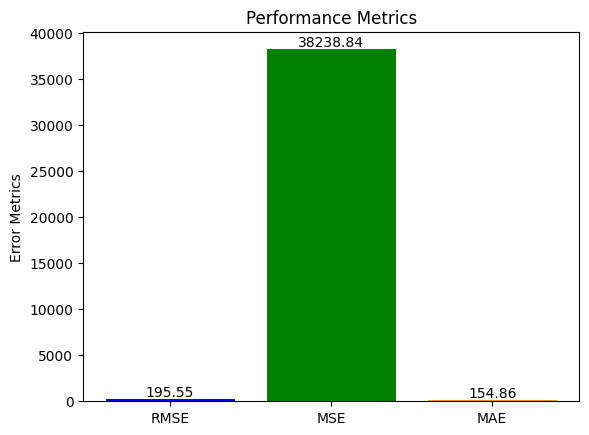

In [ ]:
# Plot the scores with values displayed
labels = ['RMSE', 'MSE', 'MAE']
values = [rmse_value, mse_value, mae_value]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green', 'orange'])

# Display values on top of the bars
for bar, value in zip(bars, values):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(value, 2), ha='center', va='bottom', color='black', fontsize=10)

plt.ylabel('Error Metrics')
plt.title('Performance Metrics')
plt.show()

In [ ]:
# loss epoch 7
# Test Loss: 37662.7447
# loss epoch 13
# Test Loss: 35415.9361

### Visualizing Model Training

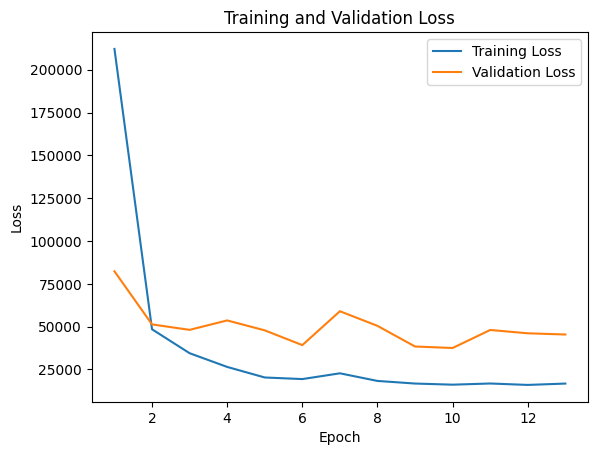

In [ ]:
# Plotting training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Split the data
train_ = df[:train_index]
val_ = df[train_index:val_index]
test_ = df[val_index:]

In [ ]:
# Convert the lists to NumPy arrays
predictions_ = np.array(predictions).squeeze()
true_values_ = np.array(actual_values)
x_values = np.array(test_.index)

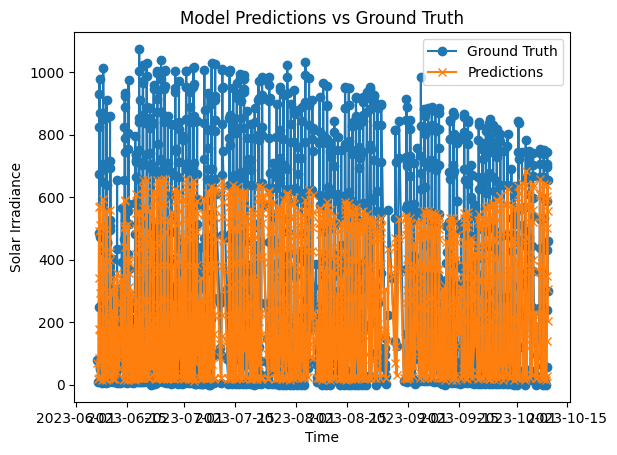

In [ ]:
# Forecasting using VGG16 Regression Model
# plt.figure(figsize=(20, 12))
plt.plot(x_values, true_values_, label='Ground Truth', marker='o')
plt.plot(x_values, predictions_, label='Predictions', marker='x')
plt.title('Model Predictions vs Ground Truth')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.legend()
plt.show()